# 1 Data Wrangling & EDA<a id='1_Data_wrangling_and_EDA'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Data Wrangling & EDA](#1_Data_wrangling_and_EDA)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Creating Data](#1.3_Creating_Data)
  * [1.4 Imports](#1.4_Imports)
  * [1.5 Load The Data](#1.5_Load_The_Data)
  * [1.6 Inspect The Data](#1.6_Inspect_The_Data)
  * [1.7 Saving The Data](#1.7_Saving_The_Data)

## 1.2 Introduction<a id='1.2_Introduction'></a>

The first step will be collecting data, organizing it, and making sure it's well defined. The aim of the project is to create a neural network that takes samples of audio and predicts the parameters needed to re-create the audio sample in the synthesizer, Serum.

## 1.3 Creating Data

To create data, we will record samples of audio from Serum and save the parameters that generated the audio. To achieve this, we will need a Digital Audio Workstation (DAW) to access the Serum and retrieve the parameters set for each Serum preset. The best DAW to implement the process with be Reaper, as it allows for a nearly unlimited amount of custom processes.



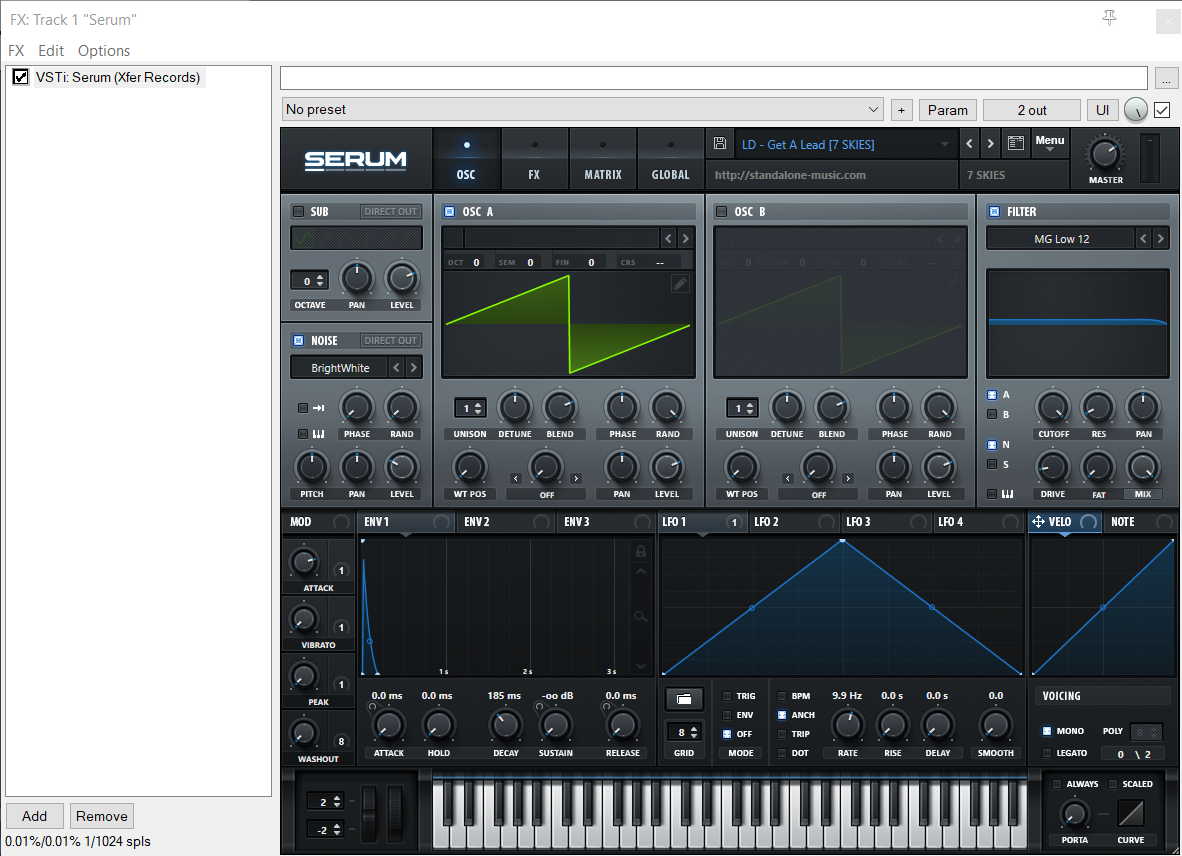
<h5><center>Serum Synthesizer</center></h5>

Here we have Serum loaded into Reaper and to generate the audio samples we will record a 2 second audio clip of the preset being played for one beat at 120 beats per minute. The functionality that allows Reaper to be so customizable is the Reaper Scripts feature. Reaper Scripts allow for writing custom code to automate processes as one makes music. We have written the following code in python and ran the script in Reaper to extract the parameters from all the Serum presets we have saved.

```
import os

vst_name = 'VSTi: Serum(Xfer Records)'
render_path = '..\\data_audio'

# Function to set a preset from a file to Serum
def set_preset(idx):
    track = RPR_GetTrack(0, 0)  # Assuming Serum is on the first track
    fx = 0  # Assuming Serum is the first FX on the track
    preset_index = idx  # Index of the preset you want to load

    RPR_TrackFX_SetPresetByIndex(track, fx , preset_index)
    
def get_total_presets(track, fx):
    # Initialize a variable to hold the number of presets
    num_presets = 0

    # This tuple will hold the current preset index, the total number of presets,
    # and whether the retrieval was successful (True/False)
    success, track, fx, num_presets = RPR_TrackFX_GetPresetIndex(track, fx, 0)
    
    # The function returns -1 if there are no presets, so check for that
    if num_presets == -1:
        return 0  # If there are no presets, return 0
    else:
        return num_presets

# Function to render the recorded audio to a file
def render_to_file(render_path, file_name):
    full_path = os.path.join(render_path)
    # Ensure the path is in the format REAPER expects
    formatted_path = full_path.replace('\\', '\\\\')
    
    # Set the render path
    RPR_GetSetProjectInfo_String(0, 'RENDER_FILE', formatted_path, True)

    # Set the render path
    RPR_GetSetProjectInfo_String(0, 'RENDER_PATTERN', file_name, True)

    # Command ID for rendering the project automatically
    RPR_Main_OnCommand(42230, 0)

def get_preset_name(track, fx):
    presetnameOut = RPR_GetSetMediaTrackInfo_String(track, 'P_NAME', '', False)[0]
    presetnameOut_sz = 256  # Define a buffer size for the preset name
    presetname = ''  # This will hold the actual preset name

    # This tuple will hold the preset name and whether the retrieval was successful (True/False)
    success, track, fx, presetname, presetnameOut_sz = RPR_TrackFX_GetPreset(track, fx, presetname, presetnameOut_sz)
    return success, presetname

# Main script execution
def main():

    track = RPR_GetTrack(0, 0)  # Get the first track
    fx = 0  # Index of Serum, assuming it is the first FX on the track
    total_presets = get_total_presets(track, fx)

    for idx in range(total_presets):
        # Load the preset into Serum
        set_preset(idx)

        # Get the preset name
        success, preset_name = get_preset_name(track, fx)
        
        files = os.listdir(render_path)

        # Adjust this line to match the file extension you are using
        file_name_with_extension = f"{preset_name}.mp3"

        files_lower = [file.lower() for file in files]

        if success:
            if file_name_with_extension.lower() not in files_lower:
                # Proceed if we successfully retrieved the preset name
                render_to_file(render_path, preset_name)
            

if __name__ == "__main__":
    main()
```

For each audio recorded, there is a corresponding now csv file that contains the parameter values used to create the audio.

## 1.4 Imports<a id='1.4_Imports'></a>

In [1]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',400)

import warnings
warnings.filterwarnings("ignore")

Now that we have the raw data saved, we will begin the process of wrangling the data to train the model in the near future. First, we import the appropriate libraries.

## 1.5 Load The Data<a id='1.5_Load_The_Data'></a>

In [2]:
audio_path = "../data/raw/data_audio"
csv_path = "../data/raw/parameters_csv"

# Gather the list directory from the audio path
presets_list = [file for file in os.listdir(audio_path)]
csv_list = [file for file in os.listdir(csv_path)]


In [12]:
presets_list[0]

'ACID - Battery.mp3'

To load the data, we need to gather the parameters for each preset and the preset file name, then combine them into a DataFrame. We create a list of the audio preset directories and the preset parameter directories. 

In [3]:
# Create DataFrame for the preset file name and its respective parameters
raw_data_dict = {}

for file in presets_list:
    
    file = file.replace('.mp3','')
    file_name = f'{file} parameters.csv'
    
    if file_name in csv_list:
        raw_data_temp = pd.read_csv(f'{csv_path}/{file} parameters.csv', skiprows=2, index_col=0)
        raw_data_dict[file] = raw_data_temp.iloc[:,1]
        
parameters = [param for param in raw_data_temp.iloc[:,0]]

Next, we initialize an empty dictionary and then combine the parameters with their corresponding preset name into a pandas DataFrame. Each DataFrame is appended into the `raw_data_dict` dictionary with the key being the name of the preset.

In [4]:
# Concatenate all DataFrames in the dictionary into one DataFrame
raw_data = pd.concat(raw_data_dict.values(), axis=1, ignore_index=True)

raw_data = raw_data.T

raw_data = pd.concat([pd.DataFrame(presets_list), raw_data], axis=1, ignore_index=True)

raw_data.columns = ['Preset'] + parameters

raw_data.head()

,Preset,MasterVol,A Vol,A Pan,A Octave,A Semi,A Fine,A Unison,A UniDet,A UniBlend,A Warp,A CoarsePit,A WTPos,A RandPhase,A Phase,B Vol,B Pan,B Octave,B Semi,B Fine,B Unison,B UniDet,B UniBlend,B Warp,B CoarsePit,B WTPos,B RandPhase,B Phase,Noise Level,Noise Pitch,Noise Fine,Noise Pan,Noise RandPhase,Noise Phase,Sub Osc Level,Sub Osc Pan,Env1 Atk,Env1 Hold,Env1 Dec,Env1 Sus,Env1 Rel,OscA>Fil,OscB>Fil,OscN>Fil,OscS>Fil,Fil Type,Fil Cutoff,Fil Reso,Fil Driv,Fil Var,Fil Mix,Fil Stereo,Env2 Atk,Env2 Hld,Env2 Dec,Env2 Sus,Env2 Rel,Env3 Atk,Env3 Hld,Env3 Dec,Env3 Sus,Env3 Rel,LFO1 Rate,LFO2 Rate,LFO3 Rate,LFO4 Rate,PortTime,PortCurve,Chaos1 BPM,Chaos2 BPM,Chaos1 Rate,Chaos2 Rate,A curve1,D curve1,R curve1,A curve2,D curve2,R curve2,A curve3,D curve3,R curve3,Mast.Tun,Verb Wet,VerbSize,Decay,VerbLoCt,Spin Rate,VerbHiCt,Spin Depth,EQ FrqL,EQ FrqH,EQ Q L,EQ Q H,EQ VolL,EQ VolH,EQ TypL,EQ TypH,Dist_Wet,Dist_Drv,Dist_L/B/H,Dist_Mode,Dist_Freq,Dist_BW,Dist_PrePost,Flg_Wet,Flg_BPM_Sync,Flg_Rate,Flg_Dep,Flg_Feed,Flg_Stereo,Phs_Wet,Phs_BPM_Sync,Phs_Rate,Phs_Dpth,Phs_Frq,Phs_Feed,Phs_Stereo,Cho_Wet,Cho_BPM_Sync,Cho_Rate,Cho_Dly,Cho_Dly2,Cho_Dep,Cho_Feed,Cho_Filt,Dly_Wet,Dly_Freq,Dly_BW,Dly_BPM_Sync,Dly_Link,Dly_TimL,Dly_TimR,Dly_Mode,Dly_Feed,Dly_Off L,Dly_Off R,Cmp_Thr,Cmp_Rat,Cmp_Att,Cmp_Rel,CmpGain,CmpMBnd,FX Fil Wet,FX Fil Type,FX Fil Freq,FX Fil Reso,FX Fil Drive,FX Fil Var,Hyp_Wet,Hyp_Rate,Hyp_Detune,Hyp_Unison,Hyp_Retrig,HypDim_Size,HypDim_Mix,Dist Enable,Flg Enable,Phs Enable,Cho Enable,Dly Enable,Comp Enable,Rev Enable,EQ Enable,FX Fil Enable,Hyp Enable,OscAPitchTrack,OscBPitchTrack,Bend U,Bend D,WarpOscA,WarpOscB,SubOscShape,SubOscOctave,A Uni LR,B Uni LR,A Uni Warp,B Uni Warp,A Uni WTPos,B Uni WTPos,A Uni Stack,B Uni Stack,Mod 1 amt,Mod 1 out,Mod 2 amt,Mod 2 out,Mod 3 amt,Mod 3 out,Mod 4 amt,Mod 4 out,Mod 5 amt,Mod 5 out,Mod 6 amt,Mod 6 out,Mod 7 amt,Mod 7 out,Mod 8 amt,Mod 8 out,Mod 9 amt,Mod 9 out,Mod10 amt,Mod10 out,Mod11 amt,Mod11 out,Mod12 amt,Mod12 out,Mod13 amt,Mod13 out,Mod14 amt,Mod14 out,Mod15 amt,Mod15 out,Mod16 amt,Mod16 out,Osc A On,Osc B On,Osc N On,Osc S On,Filter On,Mod Wheel,PITCH DOWN,WT,OCTAVES,DRY,Amp.,LFO1 smooth,LFO2 smooth,LFO3 smooth,LFO4 smooth,Pitch Bend,Mod17 amt,Mod17 out,Mod18 amt,Mod18 out,Mod19 amt,Mod19 out,Mod20 amt,Mod20 out,Mod21 amt,Mod21 out,Mod22 amt,Mod22 out,Mod23 amt,Mod23 out,Mod24 amt,Mod24 out,Mod25 amt,Mod25 out,Mod26 amt,Mod26 out,Mod27 amt,Mod27 out,Mod28 amt,Mod28 out,Mod29 amt,Mod29 out,Mod30 amt,Mod30 out,Mod31 amt,Mod31 out,Mod32 amt,Mod32 out,LFO5 Rate,LFO6 Rate,LFO7 Rate,LFO8 Rate,LFO5 smooth,LFO6 smooth,LFO7 smooth,LFO8 smooth,FX Fil Pan,Comp_Wet,CompMB L,CompMB M,CompMB H,LFO1 Rise,LFO2 Rise,LFO3 Rise,LFO4 Rise,LFO5 Rise,LFO6 Rise,LFO7 Rise,LFO8 Rise,LFO1 Delay,LFO2 Delay,LFO3 Delay,LFO4 Delay,LFO5 Delay,LFO6 Delay,LFO7 Delay,LFO8 Delay,FX Dist Level,FX Flg Level,FX Phaser Level,FX Chorus Level,FX Delay Level,FX Comp Level,FX Reverb Level,FX DimExp Level,FX Filter Level,FX Hyper Level,LFO Bus 1,LFO Bus 2,LFO Bus 3,LFO Bus 4,LFO Bus 5,LFO Bus 6,LFO Bus 7,LFO Bus 8,LFO Bus 9,LFO Bus 10,LFO Bus 11,LFO Bus 12,LFO Bus 13,LFO Bus 14,LFO Bus 15,LFO Bus 16,Bypass,Wet,Delta
0,ACID - Battery.mp3,0.64,0.75,0.5,0.24,0.5,0.5,0.00,0.50,0.75,0.0,0.5,0.00,0.3,0.08,0.00,0.5,0.27,0.5,0.5,0.0,0.50,0.75,0.0,0.5,0.00,1.0,0.5,0.95,0.65,0.5,0.5,0.0,0.0,0.75,0.5,0.11,0.0,0.50,1.0,0.22,1.0,1.0,0.0,0.0,0.14,0.14,0.56,0.31,0.00,1.0,0.5,0.11,0.0,0.50,1.0,0.22,0.11,0.0,0.50,1.0,0.22,0.50,0.32,0.67,0.50,0.33,0.5,0.0,0.0,0.25,0.25,0.4,0.6,0.6,0.4,0.6,0.6,0.4,0.6,0.6,0.5,0.27,0.35,0.35,0.32,0.25,0.35,0.2,0.31,0.67,0.48,0.60,0.43,0.67,0.5,0.0,1.0,0.54,0.00,0.2,0.50,0.50,0.0,1.0,0.0,0.25,1.0,0.5,0.5,1.00,0.0,0.25,0.5,0.5,0.8,0.5,0.50,0.0,0.25,0.5,0.0,1.0,0.1,0.5,0.22,0.46,0.00,1.0,0.0,0.62,0.62,0.0,0.26,1.0,0.5,0.43,0.75,0.3,0.21,0.00,0.0,0.00,0.91,0.56,0.11,0.43,0.72,0.29,0.40,0.25,0.57,0.0,0.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.54,0.46,0.04,0.0,0.0,0.50,1.0,1.0,0.5,0.5,0.5,0.5,0.0,0.0,0.50,1

Then, we combine all the data together and format it correctly to display as shown with the .head() method. Upon inspection, it is worth noting that the values will always lie between 0 and 1 as each parameter value is a percentage.

## 1.6 Inspect The Data<a id='1.6_Inspect_The_Data'></a>

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Columns: 319 entries, Preset to Delta
dtypes: float64(318), object(1)
memory usage: 2.4+ MB


There is only one object type and the rest are floats, as expected.

In [6]:
raw_data.describe()

,MasterVol,A Vol,A Pan,A Octave,A Semi,A Fine,A Unison,A UniDet,A UniBlend,A Warp,A CoarsePit,A WTPos,A RandPhase,A Phase,B Vol,B Pan,B Octave,B Semi,B Fine,B Unison,B UniDet,B UniBlend,B Warp,B CoarsePit,B WTPos,B RandPhase,B Phase,Noise Level,Noise Pitch,Noise Fine,Noise Pan,Noise RandPhase,Noise Phase,Sub Osc Level,Sub Osc Pan,Env1 Atk,Env1 Hold,Env1 Dec,Env1 Sus,Env1 Rel,OscA>Fil,OscB>Fil,OscN>Fil,OscS>Fil,Fil Type,Fil Cutoff,Fil Reso,Fil Driv,Fil Var,Fil Mix,Fil Stereo,Env2 Atk,Env2 Hld,Env2 Dec,Env2 Sus,Env2 Rel,Env3 Atk,Env3 Hld,Env3 Dec,Env3 Sus,Env3 Rel,LFO1 Rate,LFO2 Rate,LFO3 Rate,LFO4 Rate,PortTime,PortCurve,Chaos1 BPM,Chaos2 BPM,Chaos1 Rate,Chaos2 Rate,A curve1,D curve1,R curve1,A curve2,D curve2,R curve2,A curve3,D curve3,R curve3,Mast.Tun,Verb Wet,VerbSize,Decay,VerbLoCt,Spin Rate,VerbHiCt,Spin Depth,EQ FrqL,EQ FrqH,EQ Q L,EQ Q H,EQ VolL,EQ VolH,EQ TypL,EQ TypH,Dist_Wet,Dist_Drv,Dist_L/B/H,Dist_Mode,Dist_Freq,Dist_BW,Dist_PrePost,Flg_Wet,Flg_BPM_Sync,Flg_Rate,Flg_Dep,Flg_Feed,Flg_Stereo,Phs_Wet,Phs_BPM_Sync,Phs_Rate,Phs_Dpth,Phs_Frq,Phs_Feed,Phs_Stereo,Cho_Wet,Cho_BPM_Sync,Cho_Rate,Cho_Dly,Cho_Dly2,Cho_Dep,Cho_Feed,Cho_Filt,Dly_Wet,Dly_Freq,Dly_BW,Dly_BPM_Sync,Dly_Link,Dly_TimL,Dly_TimR,Dly_Mode,Dly_Feed,Dly_Off L,Dly_Off R,Cmp_Thr,Cmp_Rat,Cmp_Att,Cmp_Rel,CmpGain,CmpMBnd,FX Fil Wet,FX Fil Type,FX Fil Freq,FX Fil Reso,FX Fil Drive,FX Fil Var,Hyp_Wet,Hyp_Rate,Hyp_Detune,Hyp_Unison,Hyp_Retrig,HypDim_Size,HypDim_Mix,Dist Enable,Flg Enable,Phs Enable,Cho Enable,Dly Enable,Comp Enable,Rev Enable,EQ Enable,FX Fil Enable,Hyp Enable,OscAPitchTrack,OscBPitchTrack,Bend U,Bend D,WarpOscA,WarpOscB,SubOscShape,SubOscOctave,A Uni LR,B Uni LR,A Uni Warp,B Uni Warp,A Uni WTPos,B Uni WTPos,A Uni Stack,B Uni Stack,Mod 1 amt,Mod 1 out,Mod 2 amt,Mod 2 out,Mod 3 amt,Mod 3 out,Mod 4 amt,Mod 4 out,Mod 5 amt,Mod 5 out,Mod 6 amt,Mod 6 out,Mod 7 amt,Mod 7 out,Mod 8 amt,Mod 8 out,Mod 9 amt,Mod 9 out,Mod10 amt,Mod10 out,Mod11 amt,Mod11 out,Mod12 amt,Mod12 out,Mod13 amt,Mod13 out,Mod14 amt,Mod14 out,Mod15 amt,Mod15 out,Mod16 amt,Mod16 out,Osc A On,Osc B On,Osc N On,Osc S On,Filter On,Mod Wheel,PITCH DOWN,WT,OCTAVES,DRY,Amp.,LFO1 smooth,LFO2 smooth,LFO3 smooth,LFO4 smooth,Pitch Bend,Mod17 amt,Mod17 out,Mod18 amt,Mod18 out,Mod19 amt,Mod19 out,Mod20 amt,Mod20 out,Mod21 amt,Mod21 out,Mod22 amt,Mod22 out,Mod23 amt,Mod23 out,Mod24 amt,Mod24 out,Mod25 amt,Mod25 out,Mod26 amt,Mod26 out,Mod27 amt,Mod27 out,Mod28 amt,Mod28 out,Mod29 amt,Mod29 out,Mod30 amt,Mod30 out,Mod31 amt,Mod31 out,Mod32 amt,Mod32 out,LFO5 Rate,LFO6 Rate,LFO7 Rate,LFO8 Rate,LFO5 smooth,LFO6 smooth,LFO7 smooth,LFO8 smooth,FX Fil Pan,Comp_Wet,CompMB L,CompMB M,CompMB H,LFO1 Rise,LFO2 Rise,LFO3 Rise,LFO4 Rise,LFO5 Rise,LFO6 Rise,LFO7 Rise,LFO8 Rise,LFO1 Delay,LFO2 Delay,LFO3 Delay,LFO4 Delay,LFO5 Delay,LFO6 Delay,LFO7 Delay,LFO8 Delay,FX Dist Level,FX Flg Level,FX Phaser Level,FX Chorus Level,FX Delay Level,FX Comp Level,FX Reverb Level,FX DimExp Level,FX Filter Level,FX Hyper Level,LFO Bus 1,LFO Bus 2,LFO Bus 3,LFO Bus 4,LFO Bus 5,LFO Bus 6,LFO Bus 7,LFO Bus 8,LFO Bus 9,LFO Bus 10,LFO Bus 11,LFO Bus 12,LFO Bus 13,LFO Bus 14,LFO Bus 15,LFO Bus 16,Bypass,Wet,Delta
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.00000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,100

As expected, all the values will lie between 0 and 1. A unique aspect of the problem we are trying to solve when it comes to the values of the parameters is that a simple change in one of the parameters could drastically change the output of the audio. Although there may be some parameters that are far and few between in the dataset, the use of the parameter could completely change the output. 

In [7]:
missing = pd.concat([raw_data.isnull().sum(), 100 * raw_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'], ascending = False)

,count,%
Dly Enable,1,0.099701
Mod15 out,1,0.099701
Filter On,1,0.099701
Osc S On,1,0.099701
Osc N On,1,0.099701
...,...,...
Flg_BPM_Sync,1,0.099701
Flg_Wet,1,0.099701
Dist_PrePost,1,0.099701
Dist_BW,1,0.099701


Checking for missing values, we see that there is likely one row with missing values.

In [8]:
raw_data.dropna(inplace=True)

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 1001
Columns: 319 entries, Preset to Delta
dtypes: float64(318), object(1)
memory usage: 2.4+ MB


As we suspected, it was only one row with missing values. Therefore, we will not be losing predictive power in our neural network by dropping the missing values.

## 1.7 Saving The Data<a id='1.7_Saving_The_Data'></a>

In [10]:
raw_data.to_csv('../data/interim/combined_data.csv')

Finally, the new combined dataset is saved for the next steps.